In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
from sklearn import manifold, datasets, decomposition
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
import random
from scipy import ndimage
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

In [ ]:
# Define tSNE function
def tsne_clustering(data, Y, n_components, suppress_output=False):
  n_iter = 250
  perplexity = 20
  cterm = Y
  print("\n\nPerplexity = ", perplexity)
  tsne = manifold.TSNE(n_components=n_components, init='random', method='barnes_hut', random_state=0, perplexity=perplexity,n_iter=n_iter, verbose=2)
  Y = tsne.fit_transform(data)
  if n_components == 2:
    if not suppress_output:
      fig = plt.figure(figsize=(8, 6))
      ax = plt.axes()
      string = "Perplexity = " + str(perplexity)
      plt.title(string)
      cmap = matplotlib.cm.get_cmap('magma')
      normalize = matplotlib.colors.Normalize(vmin=min(cterm), vmax=max(cterm))
      colors = [cmap(normalize(value)) for value in cterm]
      sc = plt.scatter(Y[:,0], Y[:,1], color=colors, s=8)
      cax, _ = matplotlib.colorbar.make_axes(ax)
      cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
      plt.show()
  return Y

Consider the dataset $f:\chi\rightarrow Y$. Here, $\chi$ is mnist_training_data[i][0][0] and $Y$ is mnist_training_data[i][1]

In [ ]:
batch_size = 32

# load training data downloaded into data/ folder
mnist_training_data = torchvision.datasets.MNIST('data/', train=True, download=True,
                                                 transform=torchvision.transforms.Compose([
                                                                                           torchvision.transforms.ToTensor(),
                                                                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
# load test data
mnist_test_data = torchvision.datasets.MNIST('data/', train=False, download=True,
                                                 transform=torchvision.transforms.Compose([
                                                                                           torchvision.transforms.ToTensor(),
                                                                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
X = []
Y = []
for i in range(len(mnist_training_data)):
  X.append(mnist_training_data[i][0][0].flatten().detach().numpy())
  Y.append(mnist_training_data[i][1])

In [ ]:
print(len(X))
print(np.shape(X[0]))

60000
(784,)


5

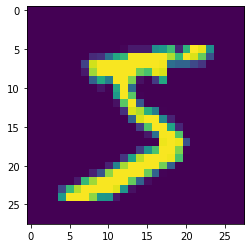

In [ ]:
# demo visual
plt.imshow(torch.tensor(X[0]).reshape((28,28)))
mnist_training_data[0][1]

$\forall y \in Y$, define the following hashmap, $D_y = \{x \in \chi | f(x) = y\}$. For this, construct $D_i, \forall i \in \{0,...,9\}$

In [ ]:
hashmaps = {}
for i in range(10):
  hashmaps[i]=[]
for i in range(len(X)):
  value = Y[i]
  hashmaps[value].append(X[i])

In [ ]:
for i in range(10):
  print(i, len(hashmaps[i]))

0 5923
1 6742
2 5958
3 6131
4 5842
5 5421
6 5918
7 6265
8 5851
9 5949


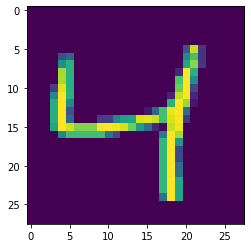

In [ ]:
plt.imshow(torch.tensor(hashmaps[4][0]).reshape((28,28)))



Perplexity =  20


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.065s...
[t-SNE] Computed neighbors for 60000 samples in 291.772s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

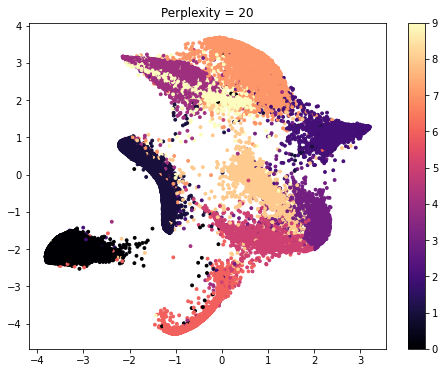

In [ ]:
tsne_data2=tsne_clustering(X,Y,2)

### Experiment 1
Naive comparision of variance estiamtes

In [ ]:
def original_data_bootstrap(hashmaps, index):
  iters = 1000
  num_samples = 600
  variances = []
  # Computating variance
  for i in range(iters):    
    laplacian = ndimage.laplace(random.sample(hashmaps[index], num_samples))
    variances.append(np.var(laplacian))
  # Calculating standard error
  mean_var = np.mean(variances)
  se = np.sqrt((1/iters) * np.sum((np.array(variances) - mean_var)**2))
  # variance_estimate = se/np.sqrt(num_samples)
  variance_estimate = np.mean(variances)
  plt.hist(variances, density=False)  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')
  plt.show()

  return variance_estimate, variances


def tsne_data_bootstrap(tsne_data, index, Y):
  tsne0 = tsne_data[np.array(Y) == index]
  iters = 1000
  num_samples = 600
  variances = []
  expectations = []
  q1 = []
  q3 = []
  for i in range(iters):
    # Estimate mean and standard error
    rand_rows = tsne0[np.random.choice(tsne0.shape[0], size=num_samples, replace=False), :]
    xvals = rand_rows[:, 0]
    # k = np.random.choice(tsne0, size = num_samples ,replace=False)
    # sample_variance = np.var(k)
    yvals = rand_rows[:, 1]
    mean_x, mean_y = np.mean(xvals), np.mean(yvals)
    q1_x, q1_y = xvals[int(len(xvals)*0.25)], yvals[int(len(xvals)*0.25)]
    q3_x, q3_y = xvals[int(len(xvals)*0.75)], yvals[int(len(xvals)*0.75)]

    S_xx = (1/num_samples) * np.sum((xvals - mean_x)**2)
    S_yy = (1/num_samples) * np.sum((yvals - mean_y)**2)
    S_xy = (1/num_samples) * np.sum((xvals - mean_x)*(yvals - mean_y))
    variance = np.sqrt(S_xx * S_yy - S_xy * S_xy)
    variances.append(variance)
    expectations.append((mean_x, mean_y))
    q1.append((q1_x, q1_y))
    q3.append((q3_x, q3_y))

  plt.hist(variances, density=False)  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')
  plt.show()


  # Calculate standard error
  mean_variance = np.mean(variances)
  # variance_estimate = np.sqrt((1/(iters)) * np.sum((np.array(variances) - mean_variance)**2))
  variance_estimate = mean_variance
  mean_val = tuple([sum(y) / len(y) for y in zip(*expectations)])
  q1_val = tuple([sum(y) / len(y) for y in zip(*q1)])
  q3_val = tuple([sum(y) / len(y) for y in zip(*q3)])
  return variance_estimate, variances, list(mean_val), list(q1_val), list(q3_val)

Class number: 0


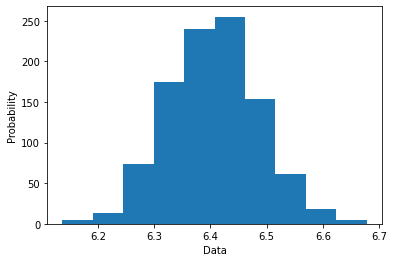

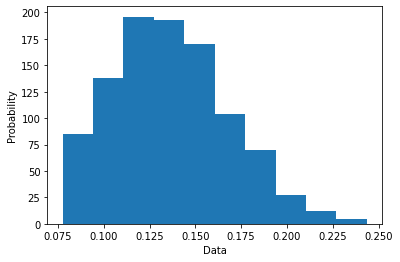

0.1367421962178148 6.405405


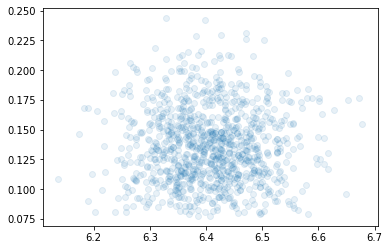

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[ 1.00000000e+00 -4.10378587e-04]
 [-4.10378587e-04  1.00000000e+00]]
Class number: 1


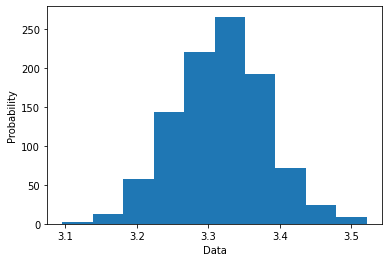

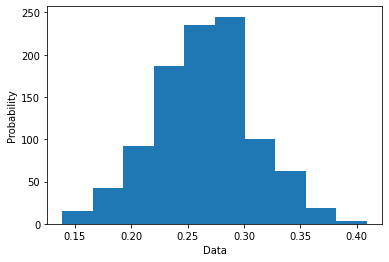

0.26485215996037836 3.31699


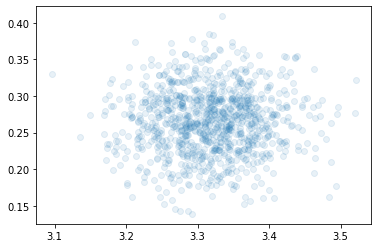

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[1.         0.02370406]
 [0.02370406 1.        ]]
Class number: 2


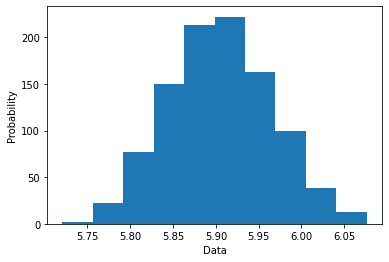

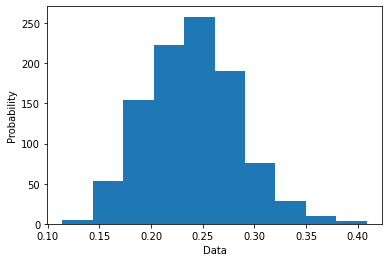

0.24034376641131025 5.9053354


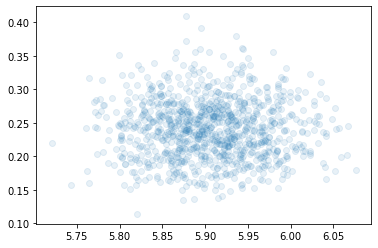

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[ 1.         -0.00827027]
 [-0.00827027  1.        ]]
Class number: 3


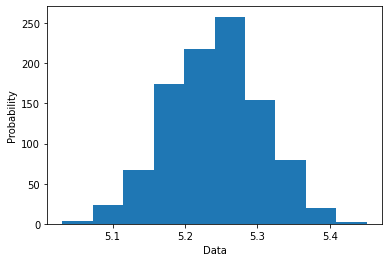

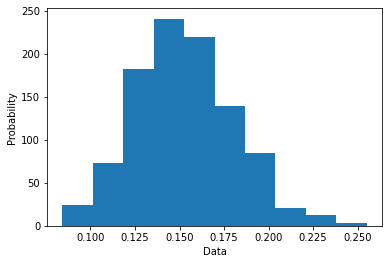

0.15292675313725898 5.2412577


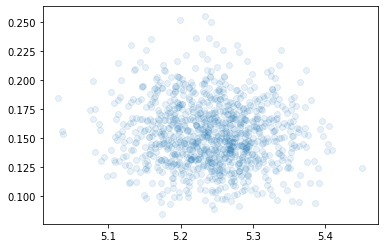

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[ 1.         -0.07896144]
 [-0.07896144  1.        ]]
Class number: 4


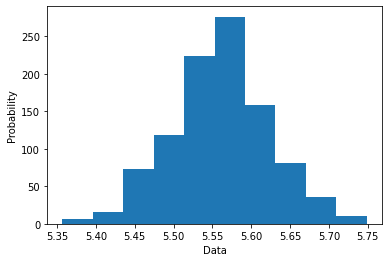

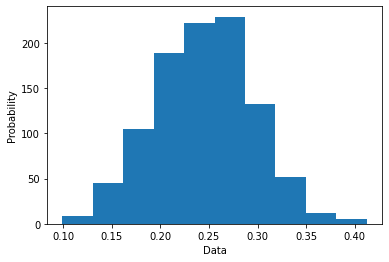

0.24482901790585895 5.5604615


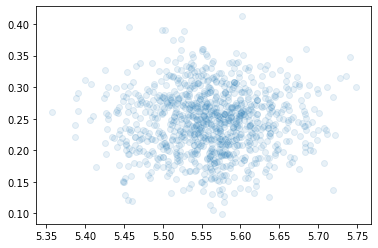

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[1.         0.01069722]
 [0.01069722 1.        ]]
Class number: 5


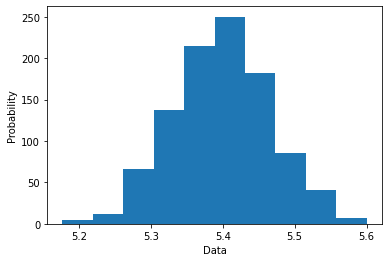

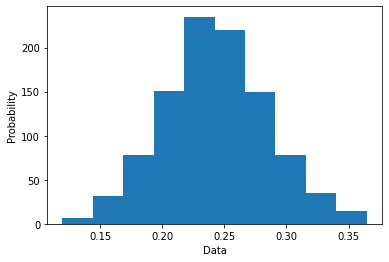

0.24291514223212526 5.398541


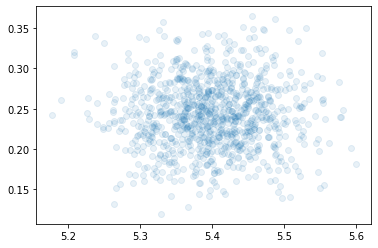

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[1.         0.00206549]
 [0.00206549 1.        ]]
Class number: 6


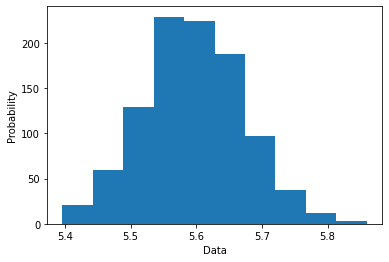

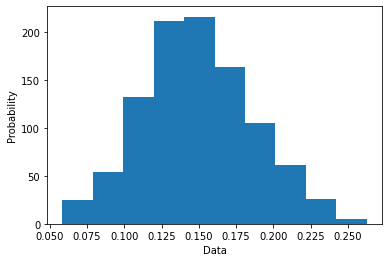

0.14917369285046272 5.596072


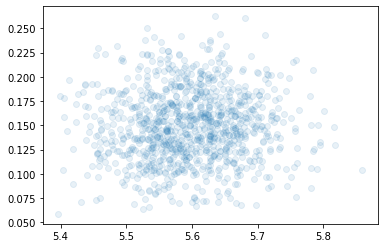

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[1.         0.02939821]
 [0.02939821 1.        ]]
Class number: 7


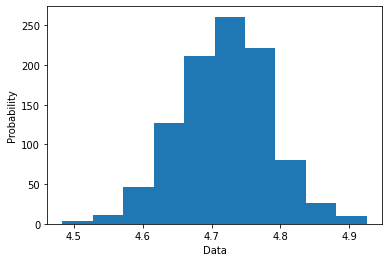

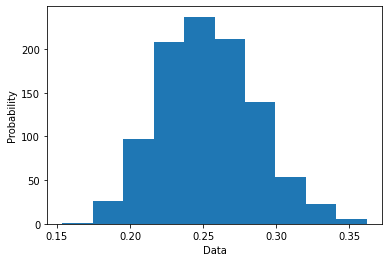

0.2531201709290229 4.7196283


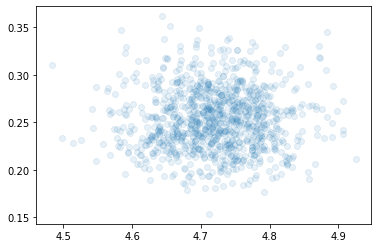

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[1.         0.00935611]
 [0.00935611 1.        ]]
Class number: 8


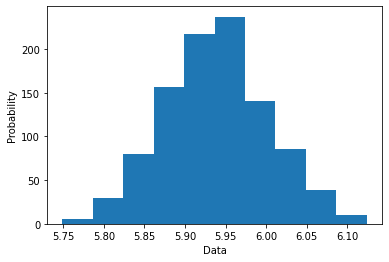

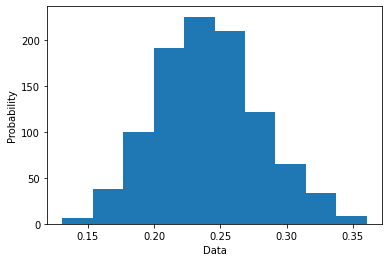

0.24079950533611205 5.938636


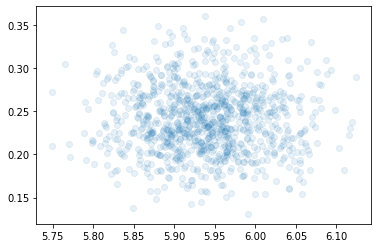

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[ 1.         -0.00516108]
 [-0.00516108  1.        ]]
Class number: 9


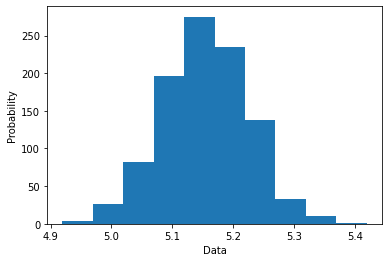

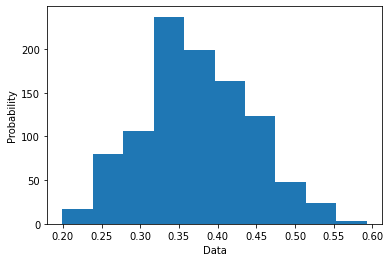

0.37244105130936156 5.1549587


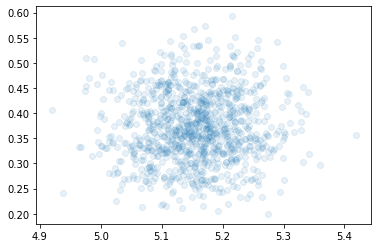

Ks_2sampResult(statistic=1.0, pvalue=0.0)
[[1.         0.03040913]
 [0.03040913 1.        ]]
[6.268662848337849, 3.052137738721262, 5.664991659919256, 5.088330914404245, 5.315632503242822, 5.1556258314312045, 5.446898504109987, 4.466508163116387, 5.697836320774728, 4.7825176736662245]


In [ ]:
from scipy.stats import ks_2samp
v_org = []
v_tsne = []
v_plot = []
expectations = []
q1 = []
q3 = []

for number in range(10):
  print("Class number: " + str(number))
  v, v_s = original_data_bootstrap(hashmaps, number)
  v_org.append(v)
  # tsne_var, tsne_mean, q1_val, q3_val = tsne_data_bootstrap(number, Y)
  tsne_var, variances, tsne_mean, q1_val, q3_val = tsne_data_bootstrap(tsne_data2, number, Y)
  v_tsne.append(tsne_var)
  expectations.append(tsne_mean)
  print(tsne_var, v_org[number])
  plt.scatter(v_s, variances, alpha = 0.1)
  plt.show()
  q1.append(q1_val)
  q3.append(q3_val)
  v_plot.append(np.abs(tsne_var - v_org[number]))

  #perform Kolmogorov-Smirnov test
  # p value almost zero => not from same distribution, and no correlation
  print(ks_2samp(v_s, variances))
  # No correlation too!
  print(np.corrcoef(v_s, variances))
print(v_plot)

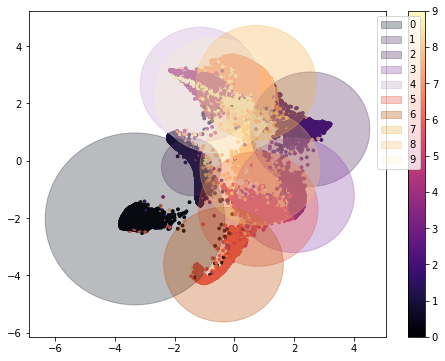

In [ ]:
# colorscheme
v = [(0.09019607843137255, 0.12549019607843137, 0.16470588235294117),
     (0.3176470588235294, 0.1803921568627451, 0.37254901960784315),
     (0.2901960784313726, 0.13725490196078433, 0.35294117647058826),
     (0.5568627450980392, 0.26666666666666666, 0.6784313725490196),
     (0.7647058823529411, 0.6078431372549019, 0.8274509803921568),
     (0.9058823529411765, 0.2980392156862745, 0.23529411764705882),
     (0.7294117647058823, 0.2901960784313726, 0.0),
     (0.9607843137254902, 0.6901960784313725, 0.2549019607843137),
     (0.9725490196078431, 0.7686274509803922, 0.44313725490196076),
     (0.9882352941176471, 0.9529411764705882, 0.8117647058823529)]


# v = [(0.56091847477176702, 0.4337815920028113, 0.40529993322542174),
# (0.9019057645364922, 0.40486281920262385, 0.44494660434372696),
# (0.14017787135673926, 0.14453863125578225, 0.1152834973874785),
# (0.63083267993295664, 0.41490272250539673, 0.45426459756164661),
# (0.77697859494133705, 0.36303988219222216, 0.45998152286644078),
# (0.16591743275750348, 0.50284988955520828, 0.43123267768728824),
# (0.16591743275750348, 0.60284988955520828, 0.43123267768728824),
# (0.16591743275750348, 0.70284988955520828, 0.43123267768728824),
# (0.15406618756053894, 0.37407489744412198, 0.87185891499533911),
# (0.20019069588580043, 0.32419824445157241, 0.67561105966262723)]

#tsne_plot
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
cmap = matplotlib.cm.get_cmap('magma')
normalize = matplotlib.colors.Normalize(vmin=min(Y), vmax=max(Y))
colors = [cmap(normalize(value)) for value in Y]
sc = plt.scatter(tsne_data2[:,0], tsne_data2[:,1], color=colors, s=8)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
circles = []

for i in range(10):
  radius = v_plot[i]//2
  circle_x=plt.Circle(expectations[i],radius, alpha=0.3, label='Index' + str(i), color = v[i])
  circles.append(circle_x)
  ax.add_patch(circle_x)
plt.legend(circles, range(0, 10))
plt.show()

[6.268662848337849, 3.052137738721262, 5.664991659919256, 5.088330914404245, 5.315632503242822, 5.1556258314312045, 5.446898504109987, 4.466508163116387, 5.697836320774728, 4.7825176736662245]
[6.268662848337849, 3.052137738721262, 5.664991659919256, 5.088330914404245, 5.315632503242822, 5.1556258314312045, 5.446898504109987, 4.466508163116387, 5.697836320774728, 4.7825176736662245]
[6.268662848337849, 3.052137738721262, 5.664991659919256, 5.088330914404245, 5.315632503242822, 5.1556258314312045, 5.446898504109987, 4.466508163116387, 5.697836320774728, 4.7825176736662245]
[6.268662848337849, 3.052137738721262, 5.664991659919256, 5.088330914404245, 5.315632503242822, 5.1556258314312045, 5.446898504109987, 4.466508163116387, 5.697836320774728, 4.7825176736662245]
[6.268662848337849, 3.052137738721262, 5.664991659919256, 5.088330914404245, 5.315632503242822, 5.1556258314312045, 5.446898504109987, 4.466508163116387, 5.697836320774728, 4.7825176736662245]
[6.268662848337849, 3.0521377387212

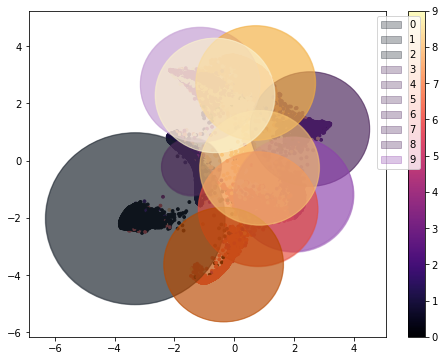

In [ ]:
#multiple_circles centered at q1, mean, q3

fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
cmap = matplotlib.cm.get_cmap('magma')
normalize = matplotlib.colors.Normalize(vmin=min(Y), vmax=max(Y))
colors = [cmap(normalize(value)) for value in Y]
sc = plt.scatter(tsne_data2[:,0], tsne_data2[:,1], color=colors, s=8)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
circles = []

for i in range(10):
  radius = v_plot[i]//2
  print(v_plot)
  circle_x=plt.Circle(expectations[i],radius, alpha=0.3, label='Index' + str(i), color = v[i])
  circle_y=plt.Circle(q1[i],radius, alpha=0.3, label='Index' + str(i), color = v[i])
  circle_z=plt.Circle(q3[i],radius, alpha=0.3, label='Index' + str(i), color = v[i])
  circles.append(circle_x)
  circles.append(circle_y)
  circles.append(circle_z)
  ax.add_patch(circle_x)
  ax.add_patch(circle_y)
  ax.add_patch(circle_z)
plt.legend(circles, range(0, 10))
plt.show()

In [ ]:
def tsne_data_bootstrap_ellipse(tsne_data, index, Y):
  tsne0 = tsne_data[np.array(Y) == index]
  iters = 200
  num_samples = 600
  variances_x = []
  variances_y = []
  expectations = []

  for i in range(iters):
    # Estimate mean and standard error
    rand_rows = tsne0[np.random.choice(tsne0.shape[0], size=num_samples, replace=False), :]
    mean_x, mean_y = np.mean(rand_rows[:, 0]), np.mean(rand_rows[:, 1])
    variance_x = np.sum((rand_rows[:, 0] - mean_x)**2)
    variance_y = np.sum((rand_rows[:, 1] - mean_y)**2)
    variances_x.append(variance_x)
    variances_y.append(variance_y)
    expectations.append((mean_x, mean_y))

  # Calculate standard error
  mean_variance_x, mean_variance_y = np.mean(variances_x), np.mean(variances_y)
  # variance_estimate_x = np.sqrt((1/(num_samples*iters)) * np.sum((variances_x - mean_variance_x)**2))
  # variance_estimate_y = np.sqrt((1/(num_samples*iters)) * np.sum((variances_y - mean_variance_y)**2))
  mean_val = tuple([sum(y) / len(y) for y in zip(*expectations)])
  return mean_variance_x, mean_variance_y, list(mean_val)

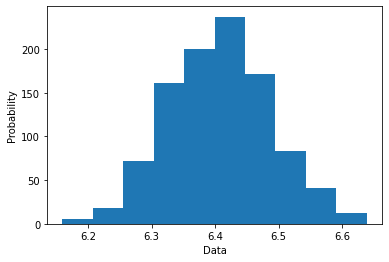

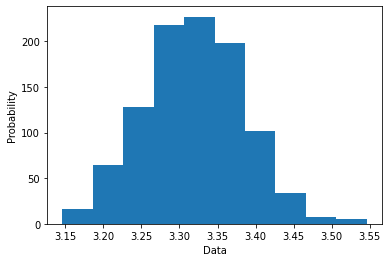

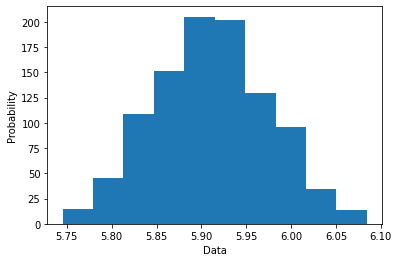

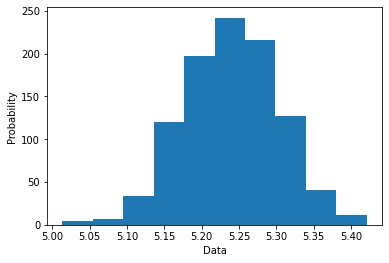

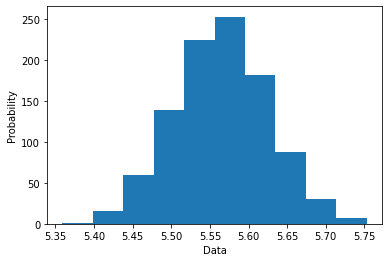

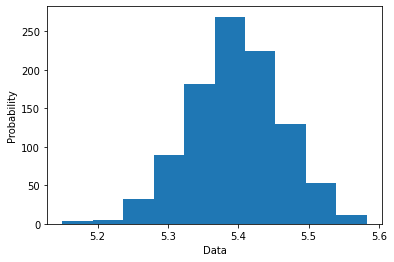

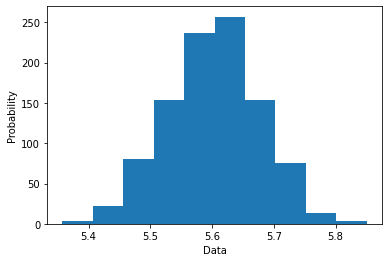

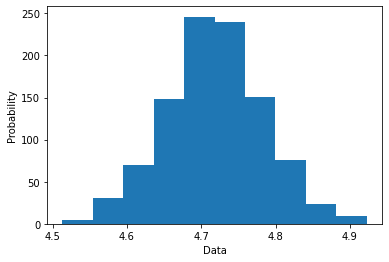

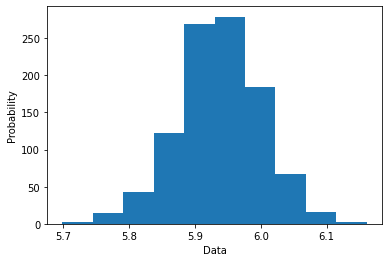

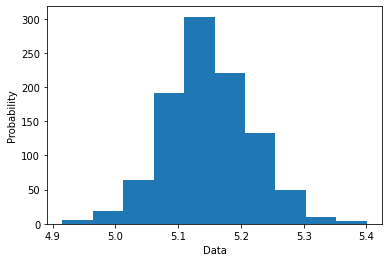

In [ ]:
v_tsne_x = []
v_tsne_y = []
v_plot = []
expectations_ellipse = []

for number in range(10):
  v_org.append(original_data_bootstrap(hashmaps, number)[0])
  tsne_var_x, tsne_var_y, tsne_mean = tsne_data_bootstrap_ellipse(tsne_data2, number, Y)
  v_tsne_x.append(tsne_var_x)
  v_tsne_y.append(tsne_var_y)
  expectations_ellipse.append(tsne_mean)
  v_plot.append([np.abs(tsne_var_x - v_org[number]), np.abs(tsne_var_y - v_org[number])])

In [ ]:
expectations_ellipse

[[-3.3244046425819396, -2.034043844938278],
 [-1.4418613159656524, -0.22108179412782192],
 [2.525787197351456, 1.096552505493164],
 [2.00662238240242, -1.2095563352108],
 [-1.1496133649349212, 2.6548214709758757],
 [0.797244459092617, -1.6885218727588653],
 [-0.3634052257239819, -3.6261135745048523],
 [0.7244580867886543, 2.71767773270607],
 [0.8464075830578804, -0.2522781424224377],
 [-0.6515737080574036, 2.2758097898960115]]

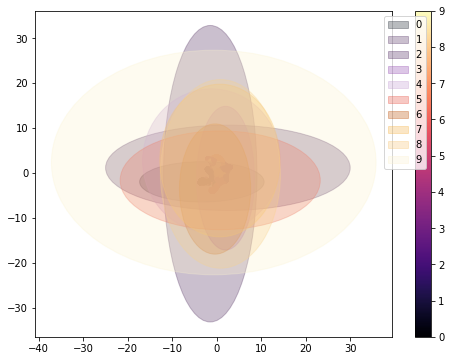

In [ ]:
#ellipses instead of circles

fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
cmap = matplotlib.cm.get_cmap('magma')
normalize = matplotlib.colors.Normalize(vmin=min(Y), vmax=max(Y))
colors = [cmap(normalize(value)) for value in Y]
sc = plt.scatter(tsne_data2[:,0], tsne_data2[:,1], color=colors, s=8)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
circles = []

for i in range(10):
  radius_x = v_plot[i][0]//5
  radius_y = v_plot[i][1]//5
  circle=Ellipse(xy=expectations_ellipse[i], width=radius_x, height=radius_y, alpha=0.3, label='Index' + str(i), color = v[i])
  circles.append(circle)
  ax.add_patch(circle)
plt.legend(circles, range(0, 10))
plt.show()